In [1]:
from typing import NamedTuple
import sympy as sym
from sympy.utilities.lambdify import lambdastr
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.display import display, Markdown
from scipy import integrate
from scipy.integrate import solve_bvp, solve_ivp
from scipy.special import jv
from scipy import optimize
from typing import Callable
# from __module_initialize_v0 import *
from module_initialize import *

In [2]:
def create_experiment(main_wave: bool, oblique_wave: bool, shear_flow: bool):
    POF = module_POF(main_wave = main_wave, oblique_wave = oblique_wave, shear_flow = shear_flow)
    members = (attr for attr in dir(POF) if not callable(getattr(POF, attr)) and not (attr.startswith("__") or attr.startswith("_")))
    methods = (attr for attr in dir(POF) if callable(getattr(POF, attr)) and not (attr.startswith("__") or attr.startswith("_")))

    for member in members if members else []:
        globals()[member] = getattr(POF, member)

    for method in methods if methods else []:
        globals()[method] = getattr(POF, method)
    
    del POF

    return bool(members) or bool(methods)

In [3]:
if_main_wave = True
if_oblique_wave = True
if_shear_flow = True
create_experiment(main_wave = if_main_wave, oblique_wave = if_oblique_wave, shear_flow = if_shear_flow)

True

In [43]:
def get_stokes_drift(verbose = False):

    # Us0
    verbose_print(verbose, 'Initial wave: ')
    verbose_display(verbose, sym.Eq(sym_phi0_symbol, sym_phi0))
    sym_u0x, sym_u0y, sym_u0z = (sym_phi0.diff(var) for var in (sym_x, sym_y, sym_z))

    sym_Us0x = (sym.I * sym_u0y / sym_omega * sym_u0x.conjugate()).diff(sym_y) + \
                (sym.I * sym_u0z / sym_omega * sym_u0x.conjugate()).diff(sym_z)
    sym_Us0x = sym_Us0x / 2
    sym_Us0y = 0
    sym_Us0x = sym_Us0x.subs(sym_psi0, - sym.I * sym_omega * sym_h0) #!!!!!!!!!
    sym_Us0x = sym_Us0x.simplify()
    
    verbose_display(verbose, sym.Eq(sym.Symbol(r'U^{s0}_x'), sym_Us0x))

    # dUs
    verbose_print(verbose, 'Oblique wave: ')
    verbose_display(verbose, sym.Eq(sym_dphi_symbol, sym_dphi))
    sym_dux, sym_duy, sym_duz = (sym_dphi.diff(var) for var in (sym_x, sym_y, sym_z))

    sym_dUsx = (sym.I * sym_duy / sym_omega * (sym_u0x).conjugate()).diff(sym_y) + \
                (sym.I * sym_duz / sym_omega * (sym_u0x).conjugate()).diff(sym_z) + \
                ((sym.I * sym_u0y / sym_omega).conjugate() * sym_dux).diff(sym_y) + \
                ((sym.I * sym_u0z / sym_omega).conjugate() * sym_dux).diff(sym_z)
    sym_dUsx = sym_dUsx / 2
    sym_dUsy = (sym.I * sym_dux / sym_omega * (sym_u0y).conjugate()).diff(sym_x) + \
                (sym.I * sym_duz / sym_omega * (sym_u0y).conjugate()).diff(sym_z) + \
                ((sym.I * sym_u0x / sym_omega).conjugate() * sym_duy).diff(sym_x) + \
                ((sym.I * sym_u0z / sym_omega).conjugate() * sym_duy).diff(sym_z)
    sym_dUsy = sym_dUsy / 2
    
    sym_dUsx = sym_dUsx.subs(sym_psi0, - sym.I * sym_omega * sym_h0)
    sym_dUsy = sym_dUsy.subs(sym_psi0, - sym.I * sym_omega * sym_h0)

    sym_dUsx = sym_dUsx.simplify()
    sym_dUsy = sym_dUsy.simplify()

    verbose_display(verbose, sym.Eq(sym.Symbol(r'\delta U^s_x'), sym_dUsx))
    verbose_display(verbose, sym.Eq(sym.Symbol(r'\delta U^s_y'), sym_dUsy))

    return (sym_Us0x, sym_Us0y, 0), (sym_alpha * sym_dUsx, sym_alpha * sym_dUsy, 0)


def get_vortex_force(verbose = False):

    sym_Us0_vec, sym_dUs_vec = get_stokes_drift(verbose = verbose)
     
    sym_vec_O0 = (0, sym_O0, 0)

    sym_dfV_1 = vector_mult(sym_Us0_vec, sym_vec_dO) 
    sym_dfV_2 = vector_mult(sym_dUs_vec, sym_vec_O0)

    sym_dfV = tuple(map(lambda x, y: x + y, sym_dfV_1, sym_dfV_2))
    sym_dfV = simplify_vector(sym_dfV)
    sym_curl_dfV = curl(sym_dfV)
    sym_curl_dfV = simplify_vector(sym_curl_dfV)

    verbose_display(verbose, sym.Eq(sym.Symbol(r'\delta{f^V}_x'), sym_dfV[0]))
    verbose_display(verbose, sym.Eq(sym.Symbol(r'\delta{f^V}_y'), sym_dfV[1]))
    verbose_display(verbose, sym.Eq(sym.Symbol(r'\delta{f^V}_z'), sym_dfV[2]))
    verbose_display(verbose, sym.Eq(sym.Symbol(r'\big(\operatorname{curl}\delta{f^V}\big)_x'), sym_curl_dfV[0]))
    verbose_display(verbose, sym.Eq(sym.Symbol(r'\big(\operatorname{curl}\delta{f^V}\big)_y'), sym_curl_dfV[1]))
    verbose_display(verbose, sym.Eq(sym.Symbol(r'\big(\operatorname{curl}\delta{f^V}\big)_z'), sym_curl_dfV[2]))

    return sym_dfV, sym_curl_dfV


def get_equation_dPsi(verbose = False):

    sym_dfV, sym_curl_dfV = get_vortex_force(verbose = verbose)
    sym_dfVx = sym_dfV[0]
    sym_curl_dfVx = sym_curl_dfV[0]

    laplas = lambda expr: expr.diff(sym_x, 2) + expr.diff(sym_y, 2) + expr.diff(sym_z, 2)

    sym_nu = 0

    # equation (38)
    sym_equation_dOx = (sym_lambda * sym_dOx - sym_nu * laplas(sym_dOx) + sym_V0_symbol * sym_dOx.diff(sym_x)) - \
                        sym_O0 * (sym_dOz + sym_dVx.diff(sym_y)) - sym_curl_dfVx
    sym_equation_dOx = sym_equation_dOx.simplify()

    # equation (39)
    sym_equation_dVx = (sym_lambda * sym_dVx - sym_nu * laplas(sym_dVx) + sym_V0_symbol * sym_dVx.diff(sym_x)) + \
                        sym_dVz * sym_O0 - sym_dfVx
    sym_equation_dVx = sym_equation_dVx.simplify()

    verbose_print(verbose, "Initial equations: ")
    verbose_display(verbose, sym.Eq(sym_equation_dVx, 0))
    verbose_display(verbose, sym.Eq(sym_equation_dOx, 0))

    sym_dVx_to_dPsi = sym.solve(sym_equation_dVx, sym_dVx_symbol)[0]
    sym_dVy_to_dPsi = sym_dPsi.diff(sym_z)
    sym_dVz_to_dPsi = -sym.I * sym_theta * sym_dPsi
    sym_dVx_to_dPsi = sym_dVx_to_dPsi.subs(sym_dVz_symbol, sym_dVz_to_dPsi)

    verbose_display(verbose, sym.Eq(sym_dVx_symbol, sym_dVx_to_dPsi))
    verbose_display(verbose, sym.Eq(sym_dVy_symbol, sym_dVy_to_dPsi))
    verbose_display(verbose, sym.Eq(sym_dVz_symbol, sym_dVz_to_dPsi))

    substitutions_dV_to_dPsi = ((sym_dVx_symbol, sym_dVx_to_dPsi), (sym_dVy_symbol, sym_dVy_to_dPsi), (sym_dVz_symbol, sym_dVz_to_dPsi))
    sym_equation_dPsi = substitute(sym_equation_dOx, substitutions_dV_to_dPsi)
    sym_equation_dPsi = sym_equation_dPsi.simplify()

    over_prefactor = sym.exp(-sym.I * sym_theta * sym_y - sym_lambda * sym_t)
    sym_equation_dPsi = sym_equation_dPsi * over_prefactor
    sym_equation_dPsi = sym_equation_dPsi.simplify()

    sym_equation_dPsi = sym_equation_dPsi.simplify().simplify()
    sym_equation_dPsi = simplify_eq_with_assumptions(sym.Eq(sym_equation_dPsi, 0)).lhs
    sym_equation_dPsi = sym_equation_dPsi.simplify()

    verbose_print(verbose, "Final equation: ")
    verbose_display(verbose, sym.Eq(sym_equation_dPsi, 0))

    return sym_equation_dPsi, substitutions_dV_to_dPsi


def get_main_equations(small_theta_factor = None, verbose = False, super_verbose = False):

    # Printing global dimensionless substitutions
    if super_verbose: print_substitutions(substitutions_dimensionless)

    # Getting dPsi equation
    sym_equation_dPsi, substitutions_dV_to_dPsi = get_equation_dPsi(verbose = super_verbose)
    sym_d2z_dPsi_expr = sym.solve(sym_equation_dPsi, sym_d2z_dPsi)[0]
    verbose_display(verbose, sym.Eq(sym_d2z_dPsi, sym_d2z_dPsi_expr))
    if verbose: print_substitutions(substitutions_dV_to_dPsi)


    # First boundary condition
    verbose_print(verbose, 'First bc: ')
    sym_bc_1 = sym_bc_1_initial
    verbose_display(verbose, sym_bc_1)
    sym_bc_1 = substitute(sym_bc_1, substitutions_dV_to_dPsi).simplify()
    verbose_display(super_verbose, sym_bc_1)
    # Dimensionless substitution
    sym_bc_1 = substitute(sym_bc_1, substitutions_dimensionless)
    sym_bc_1 = sym_bc_1.simplify()
    sym_bc_1 = simplify_eq_with_assumptions(sym.Eq(sym_bc_1, 0)).lhs
    verbose_display(verbose, sym_bc_1)

    # Second boundary condition
    verbose_print(verbose, 'Second bc: ')
    sym_bc_2 = sym_bc_2_initial
    verbose_display(verbose, sym_bc_2)
    substitutions_dp = ((sym_dp_symbol, sym_dp), (sym_dp_int_symbol, sym_dp_int))
    sym_bc_2 = substitute(sym_bc_2, substitutions_dp).simplify()
    verbose_display(super_verbose, sym_bc_2)
    sym_bc_2 = substitute(sym_bc_2, substitutions_dV_to_dPsi).simplify()
    verbose_display(super_verbose, sym_bc_2)
    sym_bc_2 = sym_bc_2.replace(sym_d2z_dPsi, sym_d2z_dPsi_expr).simplify()
    sym_bc_2 = simplify_eq_with_assumptions(sym.Eq(sym_bc_2, 0)).lhs
    verbose_display(super_verbose, sym_bc_2)
    # Dimensionless substitution
    sym_bc_2 = substitute(sym_bc_2, substitutions_dimensionless)
    sym_bc_2 = sym_bc_2.simplify()
    verbose_display(super_verbose, sym_bc_2)

    # Getting pressure expression
    sym_dp_int_dim = sym_bc_2.find(sym.Integral)
    sym_dp_int_dim = sym_dp_int_dim.pop() if sym_dp_int_dim else sym.S.Zero
    
    sym_bc_2 = sym_bc_2.subs(sym_dp_int_dim, sym_dp_int_dim_symbol).simplify()
    verbose_display(verbose, sym_bc_2)
    sym_bc_2 = simplify_eq_with_assumptions(sym.Eq(sym_bc_2, 0)).lhs
    verbose_display(verbose, sym_bc_2)
    verbose_display(verbose, sym.Eq(sym_dp_int_dim_symbol, sym_dp_int_dim, evaluate = False))
    verbose_print(verbose)

    # dPsi equation dimensionless substitution
    sym_equation_dPsi = substitute(sym_equation_dPsi, substitutions_dimensionless).simplify()
    sym_d2z_dPsi_dim_expr = sym.solve(sym_equation_dPsi, sym_dPsi_dim.diff(sym_z, 2))[0]
    sym_d2z_dPsi_dim_expr = sym_d2z_dPsi_dim_expr.simplify()
    verbose_display(verbose, sym.Eq(sym_d2z_dPsi_dim_symbol, sym_d2z_dPsi_dim_expr))

    # lambda equation
    if if_oblique_wave: 
        sym_bc_matrix = sym.linear_eq_to_matrix([sym_bc_1, sym_bc_2], [sym_dh_dim, sym_dpsi_dim])[0]
        sym_eq_lambda = sym_bc_matrix.det()
        sym_eq_lambda = sym_eq_lambda.simplify()
        sym_eq_lambda = simplify_eq_with_assumptions(sym.Eq(sym_eq_lambda, 0)).lhs
        sym_eq_lambda = sym_eq_lambda.subs((sym_theta**2 + 1), sym_zu**2).simplify().subs(sym_zu**2, (sym_theta**2 + 1))
        verbose_display(verbose, sym_eq_lambda)
    else:
        sym_eq_lambda = None
    

    return sym_dp_int_dim, sym_d2z_dPsi_dim_expr, sym_eq_lambda, sym_bc_matrix


def check_previous_results(sym_dp_int_dim, sym_d2z_dPsi_dim_expr, sym_eq_lambda):
    # sym_epsilon_prime = sym.Symbol(r'\epsilon^`')
    # display(sym_epsilon_prime)
    # substitution_epsilon = ((sym_epsilon, sym_epsilon_prime /(1 + sym_epsilon_prime / 4)),)

    # print_substitutions(substitution_epsilon)
    print('Initial substitutions')
    print_substitutions(substitutions_dimensionless)
    print()
    sym_mu_def_initial = sym.sqrt(2 * sym_O0 * sym_omega) * sym_h0 * sym_theta / sym_lambda
    sym_mu_expr = substitute(sym_mu_def_initial, substitutions_dimensionless).simplify()
    sym_lambda_dim_from_mu = sym.solve(sym.Eq(sym_mu_expr, sym_mu), sym_lambda_dim)[0]
    # sym_lambda_dim_from_mu = sym.sqrt(sym_epsilon) * sym_theta * sym_h0 / sym_mu
    sym_dPsi_new = sym.Function(r'\tilde{\delta{\Psi\Psi}}')(sym_z)
    # sym_dpsi_dim = sym.Symbol(r'\tilde{\delta\psi}', nonzero = True, zero = False)
    substitutions_mu = ((sym_lambda_dim, sym_lambda_dim_from_mu),
                        # (sym_dPsi_dim, sym_dPsi_dim))
                        (sym_dPsi_dim, sym_dPsi_new * sym_mu))
    # sym_dPsi_dim = sym_dPsi_new
    print_substitutions(substitutions_mu)

    # dPsi equation
    print('1) Validating eq (51) from POF')
    tmp_d2z_dPsi_dim_expr = substitute(sym_d2z_dPsi_dim_expr, substitutions_mu).simplify()
    display(tmp_d2z_dPsi_dim_expr)
    print('Small theta and small epsilon: ')
    tmp_d2z_dPsi_dim_expr_small = tmp_d2z_dPsi_dim_expr.subs(sym_theta**2 + 1, 1).simplify()
    tmp_d2z_dPsi_dim_expr_small = tmp_d2z_dPsi_dim_expr_small.series(sym_epsilon, x0 = 0, n = 1).removeO()
    tmp_d2z_dPsi_dim_expr_small = tmp_d2z_dPsi_dim_expr_small.simplify()
    display(tmp_d2z_dPsi_dim_expr_small)

    # dp integral
    print('2) Validating dp integral')
    tmp_dp_int = substitute(sym_dp_int_dim, substitutions_mu).simplify()
    display(tmp_dp_int)
    print('Small theta: ')
    tmp_dp_int_small = tmp_dp_int.subs(sym_theta**2 + 1, 1).simplify()
    display(tmp_dp_int_small)
    print('Small epsilon: ')
    integral = tmp_dp_int_small.find(sym.Integral).pop()
    tmp_dp_int_small= tmp_dp_int_small.subs(integral, sym_zu)
    expr, limits = integral.args
    expr = expr.series(sym_epsilon, x0 = 0, n = 1).removeO()
    integral = sym.Integral(expr, limits)
    tmp_dp_int_small = tmp_dp_int_small.subs(sym_zu, integral).simplify()
    display(tmp_dp_int_small)

    # mu equation
    print('3) Validating mu equation')
    tmp_eq_mu = substitute(sym_eq_lambda, substitutions_mu).simplify()
    display(tmp_eq_mu) 
    tmp_eq_mu = tmp_eq_mu.args[3]
    display(tmp_eq_mu) 
    tmp_eq_mu = tmp_eq_mu.subs(sym_dp_int_dim_symbol, tmp_dp_int)
    dp_int = tmp_eq_mu.find(sym.Integral).pop()
    display(dp_int)
    tmp_eq_mu = tmp_eq_mu.subs(dp_int, sym_dp_int_dim_symbol)
    tmp_eq_mu = tmp_eq_mu.simplify()
    display(tmp_eq_mu)
    print('Small theta: ')
    tmp_eq_mu = tmp_eq_mu.series(sym_theta, x0 = 0, n = 2).removeO()
    tmp_eq_mu = tmp_eq_mu.collect(sym_epsilon).simplify()
    tmp_eq_mu = tmp_eq_mu.args[5]
    display(tmp_eq_mu)
    print('Small epsilon: ')
    tmp_eq_mu = tmp_eq_mu.series(sym_epsilon, x0 = 0, n = 1).removeO()
    display(tmp_eq_mu)
    print('\nGamma = 0')
    tmp_eq_mu_gamma_eq_0 = tmp_eq_mu.subs(sym_gamma1, 0).simplify()
    display(tmp_eq_mu_gamma_eq_0)
    print('\nGamma = 1')
    tmp_eq_mu_gamma_eq_1 = tmp_eq_mu.subs(sym_gamma1, 1).simplify()
    display(tmp_eq_mu_gamma_eq_1)
    # print('\nBig gamma: ')
    # tmp_gamma = 1 - sym_zu
    # display(sym.Eq(sym_gamma, tmp_gamma))
    # tmp_eq_mu_gamma_near1 = tmp_eq_mu.subs(sym_gamma, tmp_gamma)
    # display(tmp_eq_mu_gamma_near1)
    # tmp_eq_mu_gamma_near1 = tmp_eq_mu_gamma_near1.series(sym_zu, x0 = 0, n = 2).removeO()
    # tmp_eq_mu_gamma_near1 = tmp_eq_mu_gamma_near1.collect(sym_epsilon).simplify()
    # display(tmp_eq_mu_gamma_near1)
    print('\n\twhere')
    dp_int_small = dp_int.series(sym_epsilon, x0 = 0, n = 1).removeO().subs(sym_theta**2 + 1, 1).simplify()
    display(sym.Eq(dp_int, dp_int_small))

In [44]:
display(sym_eq_lambda)
print()
check_previous_results(sym_dp_int_dim, sym_d2z_dPsi_dim_expr, sym_eq_lambda)


4*\alpha*\epsilon**(7/2)*\gamma**2*\theta*\tilde{\lambda}**2*h^{\scriptsize{(0)}}*Derivative(\tilde{\delta\Psi}(z), z) - 16*I*\alpha*\epsilon**(5/2)*\gamma*\theta*\tilde{\lambda}**3*h^{\scriptsize{(0)}}*Derivative(\tilde{\delta\Psi}(z), z) - 32*\alpha*\epsilon**(5/2)*\gamma*\theta*\tilde{\lambda}**2*h^{\scriptsize{(0)}}*Derivative(\tilde{\delta\Psi}(z), z) + 64*I*\alpha*\epsilon**(3/2)*\theta*\tilde{\lambda}**3*h^{\scriptsize{(0)}}*Derivative(\tilde{\delta\Psi}(z), z) + 64*\alpha*\epsilon**(3/2)*\theta*\tilde{\lambda}**2*h^{\scriptsize{(0)}}*Derivative(\tilde{\delta\Psi}(z), z) + 128*I*\alpha*sqrt(\epsilon)*\theta*\tilde{\lambda}**3*h^{\scriptsize{(0)}}*sqrt(\theta**2 + 1)*Derivative(\tilde{\delta\Psi}(z), z) - \alpha*\epsilon**4*\gamma**2*\overline{\delta{p}}^{\varpi}_{int}*\theta**2*h^{\scriptsize{(0)}}**2 - 2*I*\alpha*\epsilon**3*\gamma**2*\overline{\delta{p}}^{\varpi}_{int}*\theta**2*\tilde{\lambda}*h^{\scriptsize{(0)}}**2 + 4*I*\alpha*\epsilon**3*\gamma*\overline{\delta{p}}^{\varp


Initial substitutions
Substitutions: 


Eq(\psi^{\scriptsize{(0)}}, -I*\omega*h^{\scriptsize{(0)}})

Eq(\omega, -\Omega^{\scriptsize{(0)}}*\gamma/2 + \omega_0)

Eq(\lambda, \omega_0*\tilde{\lambda})

Eq(\Omega^{\scriptsize{(0)}}, \epsilon*\omega_0/2)

Eq(\delta\Psi(z), \delta\psi*sqrt(\epsilon)*\tilde{\delta\Psi}(z))

Eq(\delta\xi, \tilde{\delta h}*h^{\scriptsize{(0)}})

Eq(\delta\psi, \psi^{\scriptsize{(0)}}*\tilde{\delta\psi})

Eq(g, \omega_0**2)


Substitutions: 


Eq(\tilde{\lambda}, sqrt(\epsilon)*\theta*h^{\scriptsize{(0)}}*sqrt(-\epsilon*\gamma + 4)/(2*\mu))

Eq(\tilde{\delta\Psi}(z), \mu*\tilde{\delta{\Psi\Psi}}(z))

1) Validating eq (51) from POF


-\mu*(\alpha*sqrt(-\epsilon*\gamma + 4)*(sqrt(\theta**2 + 1) + 1)*exp(z*(sqrt(\theta**2 + 1) + 1)) + \mu**2*(\epsilon*\gamma - 4)*\tilde{\delta{\Psi\Psi}}(z)*exp(2*z) - \theta**2*(\epsilon*\gamma - 4)*\tilde{\delta{\Psi\Psi}}(z))/(\epsilon*\gamma - 4)

Small theta and small epsilon: 


\mu*(\alpha*exp(2*z) - \mu**2*\tilde{\delta{\Psi\Psi}}(z)*exp(2*z) + \theta**2*\tilde{\delta{\Psi\Psi}}(z))

2) Validating dp integral


sqrt(\epsilon)*\theta*h^{\scriptsize{(0)}}*Integral((\alpha*sqrt(\theta**2 + 1)*sqrt(-\epsilon*\gamma + 4)*exp(z*sqrt(\theta**2 + 1)) + \alpha*sqrt(-\epsilon*\gamma + 4)*exp(z*sqrt(\theta**2 + 1)) + \epsilon*\gamma*\mu**2*\tilde{\delta{\Psi\Psi}}(z)*exp(z) - 4*\mu**2*\tilde{\delta{\Psi\Psi}}(z)*exp(z))*exp(2*z)*exp(z*sqrt(\theta**2 + 1)), (z, -oo, 0))/\mu

Small theta: 


sqrt(\epsilon)*\theta*h^{\scriptsize{(0)}}*Integral((2*\alpha*sqrt(-\epsilon*\gamma + 4) + \epsilon*\gamma*\mu**2*\tilde{\delta{\Psi\Psi}}(z) - 4*\mu**2*\tilde{\delta{\Psi\Psi}}(z))*exp(4*z), (z, -oo, 0))/\mu

Small epsilon: 


4*sqrt(\epsilon)*\theta*h^{\scriptsize{(0)}}*Integral((\alpha - \mu**2*\tilde{\delta{\Psi\Psi}}(z))*exp(4*z), (z, -oo, 0))/\mu

3) Validating mu equation


\theta**2*h^{\scriptsize{(0)}}**2*(I*\alpha*\epsilon**(3/2)*\mu**4*\overline{\delta{p}}^{\varpi}_{int}*\theta*h^{\scriptsize{(0)}}*sqrt(-\epsilon*\gamma + 4)*(-\epsilon**2*\gamma**2 + 2*\epsilon**2*\gamma + 8*\epsilon*\gamma - 8*\epsilon - 16) + \alpha*\epsilon**2*\mu**5*\overline{\delta{p}}^{\varpi}_{int}*(-\epsilon**2*\gamma**2 + 8*\epsilon*\gamma - 16) + \alpha*\mu**3*\theta*h^{\scriptsize{(0)}}*(\epsilon*\gamma - 4)*(-\epsilon**(9/2)*\gamma**2*\mu*Derivative(\tilde{\delta{\Psi\Psi}}(z), z) + 8*\epsilon**(7/2)*\gamma*\mu*Derivative(\tilde{\delta{\Psi\Psi}}(z), z) - 16*\epsilon**(5/2)*\mu*Derivative(\tilde{\delta{\Psi\Psi}}(z), z) + 2*\epsilon**3*\gamma*\overline{\delta{p}}^{\varpi}_{int}*\theta*h^{\scriptsize{(0)}} - 8*\epsilon**2*\overline{\delta{p}}^{\varpi}_{int}*\theta*h^{\scriptsize{(0)}}) - 4*\epsilon**(5/2)*\theta**3*h^{\scriptsize{(0)}}**3*sqrt(\theta**2 + 1)*(-\epsilon*\gamma + 4)**(5/2) + 4*I*\epsilon**2*\mu*\theta**2*h^{\scriptsize{(0)}}**2*(\epsilon*\gamma - 4)**2*(-\eps

I*\alpha*\epsilon**(3/2)*\mu**4*\overline{\delta{p}}^{\varpi}_{int}*\theta*h^{\scriptsize{(0)}}*sqrt(-\epsilon*\gamma + 4)*(-\epsilon**2*\gamma**2 + 2*\epsilon**2*\gamma + 8*\epsilon*\gamma - 8*\epsilon - 16) + \alpha*\epsilon**2*\mu**5*\overline{\delta{p}}^{\varpi}_{int}*(-\epsilon**2*\gamma**2 + 8*\epsilon*\gamma - 16) + \alpha*\mu**3*\theta*h^{\scriptsize{(0)}}*(\epsilon*\gamma - 4)*(-\epsilon**(9/2)*\gamma**2*\mu*Derivative(\tilde{\delta{\Psi\Psi}}(z), z) + 8*\epsilon**(7/2)*\gamma*\mu*Derivative(\tilde{\delta{\Psi\Psi}}(z), z) - 16*\epsilon**(5/2)*\mu*Derivative(\tilde{\delta{\Psi\Psi}}(z), z) + 2*\epsilon**3*\gamma*\overline{\delta{p}}^{\varpi}_{int}*\theta*h^{\scriptsize{(0)}} - 8*\epsilon**2*\overline{\delta{p}}^{\varpi}_{int}*\theta*h^{\scriptsize{(0)}}) - 4*\epsilon**(5/2)*\theta**3*h^{\scriptsize{(0)}}**3*sqrt(\theta**2 + 1)*(-\epsilon*\gamma + 4)**(5/2) + 4*I*\epsilon**2*\mu*\theta**2*h^{\scriptsize{(0)}}**2*(\epsilon*\gamma - 4)**2*(-\epsilon*\gamma*sqrt(\theta**2 + 1) + \

Integral((\alpha*sqrt(\theta**2 + 1)*sqrt(-\epsilon*\gamma + 4)*exp(z*sqrt(\theta**2 + 1)) + \alpha*sqrt(-\epsilon*\gamma + 4)*exp(z*sqrt(\theta**2 + 1)) + \epsilon*\gamma*\mu**2*\tilde{\delta{\Psi\Psi}}(z)*exp(z) - 4*\mu**2*\tilde{\delta{\Psi\Psi}}(z)*exp(z))*exp(2*z)*exp(z*sqrt(\theta**2 + 1)), (z, -oo, 0))

\theta*h^{\scriptsize{(0)}}*(-\alpha*\epsilon**(5/2)*\mu**4*\overline{\delta{p}}^{\varpi}_{int}*(\epsilon**2*\gamma**2 - 8*\epsilon*\gamma + 16) - \alpha*\epsilon**(5/2)*\mu**2*(\epsilon*\gamma - 4)*(-2*\epsilon*\gamma*\overline{\delta{p}}^{\varpi}_{int}*\theta**2*h^{\scriptsize{(0)}}**2 + \mu**2*(\epsilon**2*\gamma**2 - 8*\epsilon*\gamma + 16)*Derivative(\tilde{\delta{\Psi\Psi}}(z), z) + 8*\overline{\delta{p}}^{\varpi}_{int}*\theta**2*h^{\scriptsize{(0)}}**2) - I*\alpha*\epsilon**2*\mu**3*\overline{\delta{p}}^{\varpi}_{int}*\theta*h^{\scriptsize{(0)}}*sqrt(-\epsilon*\gamma + 4)*(\epsilon**2*\gamma**2 - 2*\epsilon**2*\gamma - 8*\epsilon*\gamma + 8*\epsilon + 16) - 4*\epsilon**(5/2)*\theta**2*h^{\scriptsize{(0)}}**2*sqrt(\theta**2 + 1)*(-\epsilon*\gamma + 4)**(5/2) + 4*I*\epsilon**2*\mu*\theta*h^{\scriptsize{(0)}}*(\epsilon*\gamma - 4)**2*(-\epsilon*\gamma*sqrt(\theta**2 + 1) + \epsilon + 4*sqrt(\theta**2 + 1)) - \mu**2*(-\epsilon*\gamma + 4)**(3/2)*(2*I*\alpha*\epsilon**4*\gamma*\mu*\t

Small theta: 


\alpha*\mu**2*\overline{\delta{p}}^{\varpi}_{int}*(\epsilon**2*\gamma**2 - 8*\epsilon*\gamma + 16) - 4*\alpha*\mu**2*(\epsilon**2*\gamma**2 - 8*\epsilon*\gamma + 16)*Derivative(\tilde{\delta{\Psi\Psi}}(z), z) + \epsilon*\gamma*(\alpha*\mu**2*(\epsilon**2*\gamma**2 - 8*\epsilon*\gamma + 16)*Derivative(\tilde{\delta{\Psi\Psi}}(z), z) - \gamma*(-\epsilon*\gamma + 4)**(3/2) + 2*(-\epsilon*\gamma + 4)**(3/2)) + 8*\gamma*(-\epsilon*\gamma + 4)**(3/2) - 8*(-\epsilon*\gamma + 4)**(3/2)

Small epsilon: 


16*\alpha*\mu**2*\overline{\delta{p}}^{\varpi}_{int} - 64*\alpha*\mu**2*Derivative(\tilde{\delta{\Psi\Psi}}(z), z) + 64*\gamma - 64


Gamma = 0


16*\alpha*\mu**2*\overline{\delta{p}}^{\varpi}_{int} - 64*\alpha*\mu**2*Derivative(\tilde{\delta{\Psi\Psi}}(z), z) - 64


Gamma = 1


16*\alpha*\mu**2*(\overline{\delta{p}}^{\varpi}_{int} - 4*Derivative(\tilde{\delta{\Psi\Psi}}(z), z))


	where


Eq(Integral((\alpha*sqrt(\theta**2 + 1)*sqrt(-\epsilon*\gamma + 4)*exp(z*sqrt(\theta**2 + 1)) + \alpha*sqrt(-\epsilon*\gamma + 4)*exp(z*sqrt(\theta**2 + 1)) + \epsilon*\gamma*\mu**2*\tilde{\delta{\Psi\Psi}}(z)*exp(z) - 4*\mu**2*\tilde{\delta{\Psi\Psi}}(z)*exp(z))*exp(2*z)*exp(z*sqrt(\theta**2 + 1)), (z, -oo, 0)), 4*Integral((\alpha - \mu**2*\tilde{\delta{\Psi\Psi}}(_0))*exp(4*_0), (_0, -oo, 0)))

In [5]:
sym_dp_int_dim, sym_d2z_dPsi_dim_expr, sym_eq_lambda, sym_bc_matrix = get_main_equations(verbose = True, 
                                                                                         super_verbose = True)

Substitutions: 


Eq(\psi^{\scriptsize{(0)}}, -I*\omega*h^{\scriptsize{(0)}})

Eq(\omega, -\Omega^{\scriptsize{(0)}}*\gamma/2 + \omega_0)

Eq(\lambda, \omega_0*\tilde{\lambda})

Eq(\Omega^{\scriptsize{(0)}}, \epsilon*\omega_0/2)

Eq(\delta\Psi(z), \delta\psi*sqrt(\epsilon)*\tilde{\delta\Psi}(z))

Eq(\delta\xi, \tilde{\delta h}*h^{\scriptsize{(0)}})

Eq(\delta\psi, \psi^{\scriptsize{(0)}}*\tilde{\delta\psi})

Eq(g, \omega_0**2)

Initial wave: 


Eq(\phi^{\scriptsize{(0)}}, \psi^{\scriptsize{(0)}}*exp(-I*\omega*t + I*x + z))

Eq(U^{s0}_x, \omega*h^{\scriptsize{(0)}}**2*exp(2*z))

Oblique wave: 


Eq(\delta{\phi}, \delta\psi*exp(\lambda*t)*exp(-I*\omega*t + I*\theta*y + I*x + z*sqrt(\theta**2 + 1)))

Eq(\delta U^s_x, I*\delta\psi*h^{\scriptsize{(0)}}*(sqrt(\theta**2 + 1) + 1)*exp(\lambda*t + I*\theta*y + z*sqrt(\theta**2 + 1) + z))

Eq(\delta U^s_y, \delta\psi*\theta*h^{\scriptsize{(0)}}*(sqrt(-\theta**2 - 1) + I)*exp(\lambda*t + I*\theta*y + z*sqrt(\theta**2 + 1) + z)/2)

Eq(\delta{f^V}_x, 0)

Eq(\delta{f^V}_y, I*\omega*\theta*h^{\scriptsize{(0)}}**2*\delta{V}_x(z)*exp(\lambda*t + I*\theta*y + 2*z))

Eq(\delta{f^V}_z, h^{\scriptsize{(0)}}*(I*\Omega^{\scriptsize{(0)}}*\alpha*\delta\psi*(sqrt(\theta**2 + 1) + 1)*exp(\lambda*t + I*\theta*y + z*sqrt(\theta**2 + 1) + z) + \omega*h^{\scriptsize{(0)}}*exp(\lambda*t + I*\theta*y + 2*z)*Derivative(\delta{V}_x(z), z)))

Eq(\big(\operatorname{curl}\delta{f^V}\big)_x, \theta*h^{\scriptsize{(0)}}*(-\Omega^{\scriptsize{(0)}}*\alpha*\delta\psi*(sqrt(\theta**2 + 1) + 1)*exp(\lambda*t + I*\theta*y + z*sqrt(\theta**2 + 1) + z) - 2*I*\omega*h^{\scriptsize{(0)}}*\delta{V}_x(z)*exp(\lambda*t + I*\theta*y + 2*z)))

Eq(\big(\operatorname{curl}\delta{f^V}\big)_y, 0)

Eq(\big(\operatorname{curl}\delta{f^V}\big)_z, 0)

Initial equations: 


Eq((\Omega^{\scriptsize{(0)}}*\delta{V}_z(z) + \lambda*\delta{V}_x(z))*exp(\lambda*t + I*\theta*y), 0)

Eq(\lambda*(I*\theta*\delta{V}_z(z) - Derivative(\delta{V}_y(z), z))*exp(\lambda*t + I*\theta*y) + \theta*h^{\scriptsize{(0)}}*(\Omega^{\scriptsize{(0)}}*\alpha*\delta\psi*(sqrt(\theta**2 + 1) + 1)*exp(\lambda*t + I*\theta*y + z*sqrt(\theta**2 + 1) + z) + 2*I*\omega*h^{\scriptsize{(0)}}*\delta{V}_x(z)*exp(\lambda*t + I*\theta*y + 2*z)), 0)

Eq(\delta{V}_x(z), I*\Omega^{\scriptsize{(0)}}*\theta*\delta\Psi(z)/\lambda)

Eq(\delta{V}_y(z), Derivative(\delta\Psi(z), z))

Eq(\delta{V}_z(z), -I*\theta*\delta\Psi(z))

Final equation: 


Eq(-2*\Omega^{\scriptsize{(0)}}*\omega*\theta**2*h^{\scriptsize{(0)}}**2*\delta\Psi(z)*exp(2*z) + \lambda*(\Omega^{\scriptsize{(0)}}*\alpha*\delta\psi*\theta*h^{\scriptsize{(0)}}*sqrt(\theta**2 + 1)*exp(z*(sqrt(\theta**2 + 1) + 1)) + \Omega^{\scriptsize{(0)}}*\alpha*\delta\psi*\theta*h^{\scriptsize{(0)}}*exp(z*(sqrt(\theta**2 + 1) + 1)) + \lambda*\theta**2*\delta\Psi(z) - \lambda*Derivative(\delta\Psi(z), (z, 2))), 0)

Eq(Derivative(\delta\Psi(z), (z, 2)), \theta*(\Omega^{\scriptsize{(0)}}*\alpha*\delta\psi*\lambda*h^{\scriptsize{(0)}}*(sqrt(\theta**2 + 1) + 1)*exp(z*(sqrt(\theta**2 + 1) + 1)) - 2*\Omega^{\scriptsize{(0)}}*\omega*\theta*h^{\scriptsize{(0)}}**2*\delta\Psi(z)*exp(2*z) + \lambda**2*\theta*\delta\Psi(z))/\lambda**2)

Substitutions: 


Eq(\delta{V}_x(z), I*\Omega^{\scriptsize{(0)}}*\theta*\delta\Psi(z)/\lambda)

Eq(\delta{V}_y(z), Derivative(\delta\Psi(z), z))

Eq(\delta{V}_z(z), -I*\theta*\delta\Psi(z))

First bc: 


-\alpha*h^{\scriptsize{(0)}}*Derivative(\delta{V}_z(z), z) - \delta\psi*sqrt(\theta**2 + 1) + \delta\xi*(\lambda - I*\omega)

I*\alpha*\theta*h^{\scriptsize{(0)}}*Derivative(\delta\Psi(z), z) - \delta\psi*sqrt(\theta**2 + 1) + \delta\xi*(\lambda - I*\omega)

I*\alpha*sqrt(\epsilon)*\psi^{\scriptsize{(0)}}*\theta*\tilde{\delta\psi}*h^{\scriptsize{(0)}}*Derivative(\tilde{\delta\Psi}(z), z) + \omega_0*\tilde{\delta h}*h^{\scriptsize{(0)}}*(4*\tilde{\lambda} + I*(\epsilon*\gamma - 4))/4 - \psi^{\scriptsize{(0)}}*\tilde{\delta\psi}*sqrt(\theta**2 + 1)

Second bc: 


\delta\psi*(\lambda - I*\omega) + \delta\xi*g - \delta{p}^{\varpi}

(-I*\Omega^{\scriptsize{(0)}}*\delta\psi - I*\alpha*\psi^{\scriptsize{(0)}}*Derivative(\delta{V}_x(z), z) + I*\alpha*\psi^{\scriptsize{(0)}}*Integral((-\theta**2*\delta{V}_x(z) + I*\theta**2*\delta{V}_z(z) + Derivative(\delta{V}_x(z), (z, 2)) - I*Derivative(\delta{V}_z(z), (z, 2)))*exp(z)*exp(z*sqrt(\theta**2 + 1)), (z, -oo, 0)) + sqrt(\theta**2 + 1)*(\delta\psi*(\lambda - I*\omega) + \delta\xi*g))/sqrt(\theta**2 + 1)

(\Omega^{\scriptsize{(0)}}*\alpha*\psi^{\scriptsize{(0)}}*\theta*Derivative(\delta\Psi(z), z)/\lambda - I*\Omega^{\scriptsize{(0)}}*\delta\psi - \alpha*\psi^{\scriptsize{(0)}}*\theta*(\Omega^{\scriptsize{(0)}} + I*\lambda)*Integral(-\theta**2*\delta\Psi(z)*exp(z)*exp(z*sqrt(\theta**2 + 1)) + exp(z)*exp(z*sqrt(\theta**2 + 1))*Derivative(\delta\Psi(z), (z, 2)), (z, -oo, 0))/\lambda + sqrt(\theta**2 + 1)*(\delta\psi*(\lambda - I*\omega) + \delta\xi*g))/sqrt(\theta**2 + 1)

\Omega^{\scriptsize{(0)}}*\alpha*\psi^{\scriptsize{(0)}}*\theta*Derivative(\delta\Psi(z), z) - \Omega^{\scriptsize{(0)}}*\alpha*\psi^{\scriptsize{(0)}}*\theta**2*h^{\scriptsize{(0)}}*(\Omega^{\scriptsize{(0)}} + I*\lambda)*Integral((\alpha*\delta\psi*\lambda*sqrt(\theta**2 + 1)*exp(z*sqrt(\theta**2 + 1)) + \alpha*\delta\psi*\lambda*exp(z*sqrt(\theta**2 + 1)) - 2*\omega*\theta*h^{\scriptsize{(0)}}*\delta\Psi(z)*exp(z))*exp(2*z)*exp(z*sqrt(\theta**2 + 1)), (z, -oo, 0))/\lambda**2 + \lambda*(-I*\Omega^{\scriptsize{(0)}}*\delta\psi + sqrt(\theta**2 + 1)*(\delta\psi*(\lambda - I*\omega) + \delta\xi*g))

\omega_0**2*(-I*\alpha*\epsilon*\psi^{\scriptsize{(0)}}*\theta**2*\tilde{\delta\psi}*h^{\scriptsize{(0)}}**2*(\epsilon + 2*I*\tilde{\lambda})*(\epsilon*\gamma - 4)*Integral((2*\alpha*\tilde{\lambda}*sqrt(\theta**2 + 1)*exp(z*sqrt(\theta**2 + 1)) + 2*\alpha*\tilde{\lambda}*exp(z*sqrt(\theta**2 + 1)) + \epsilon**(3/2)*\gamma*\theta*h^{\scriptsize{(0)}}*\tilde{\delta\Psi}(z)*exp(z) - 4*sqrt(\epsilon)*\theta*h^{\scriptsize{(0)}}*\tilde{\delta\Psi}(z)*exp(z))*exp(2*z)*exp(z*sqrt(\theta**2 + 1)), (z, -oo, 0))/2 + 2*\tilde{\lambda}**2*(I*\alpha*\epsilon**(3/2)*\psi^{\scriptsize{(0)}}*\theta*\tilde{\delta\psi}*h^{\scriptsize{(0)}}*(\epsilon*\gamma - 4)*Derivative(\tilde{\delta\Psi}(z), z) - 2*\tilde{\lambda}*(2*I*\epsilon*\psi^{\scriptsize{(0)}}*\tilde{\delta\psi} - sqrt(\theta**2 + 1)*(4*\omega_0*\tilde{\delta h}*h^{\scriptsize{(0)}} + \psi^{\scriptsize{(0)}}*\tilde{\delta\psi}*(4*\tilde{\lambda} + I*(\epsilon*\gamma - 4))))))/(16*\tilde{\lambda}**2)

-\omega_0**2*(I*\alpha*\epsilon*\overline{\delta{p}}^{\varpi}_{int}*\psi^{\scriptsize{(0)}}*\theta**2*\tilde{\delta\psi}*h^{\scriptsize{(0)}}**2*(\epsilon + 2*I*\tilde{\lambda})*(\epsilon*\gamma - 4) - 4*\tilde{\lambda}**2*(I*\alpha*\epsilon**(3/2)*\psi^{\scriptsize{(0)}}*\theta*\tilde{\delta\psi}*h^{\scriptsize{(0)}}*(\epsilon*\gamma - 4)*Derivative(\tilde{\delta\Psi}(z), z) - 2*\tilde{\lambda}*(2*I*\epsilon*\psi^{\scriptsize{(0)}}*\tilde{\delta\psi} - sqrt(\theta**2 + 1)*(4*\omega_0*\tilde{\delta h}*h^{\scriptsize{(0)}} + \psi^{\scriptsize{(0)}}*\tilde{\delta\psi}*(4*\tilde{\lambda} + I*(\epsilon*\gamma - 4))))))/(32*\tilde{\lambda}**2)

I*\alpha*\epsilon*\overline{\delta{p}}^{\varpi}_{int}*\psi^{\scriptsize{(0)}}*\theta**2*\tilde{\delta\psi}*h^{\scriptsize{(0)}}**2*(\epsilon + 2*I*\tilde{\lambda})*(\epsilon*\gamma - 4) - 4*\tilde{\lambda}**2*(I*\alpha*\epsilon**(3/2)*\psi^{\scriptsize{(0)}}*\theta*\tilde{\delta\psi}*h^{\scriptsize{(0)}}*(\epsilon*\gamma - 4)*Derivative(\tilde{\delta\Psi}(z), z) - 2*\tilde{\lambda}*(2*I*\epsilon*\psi^{\scriptsize{(0)}}*\tilde{\delta\psi} - sqrt(\theta**2 + 1)*(4*\omega_0*\tilde{\delta h}*h^{\scriptsize{(0)}} + \psi^{\scriptsize{(0)}}*\tilde{\delta\psi}*(4*\tilde{\lambda} + I*(\epsilon*\gamma - 4)))))

Eq(\overline{\delta{p}}^{\varpi}_{int}, Integral((2*\alpha*\tilde{\lambda}*sqrt(\theta**2 + 1)*exp(z*sqrt(\theta**2 + 1)) + 2*\alpha*\tilde{\lambda}*exp(z*sqrt(\theta**2 + 1)) + \epsilon**(3/2)*\gamma*\theta*h^{\scriptsize{(0)}}*\tilde{\delta\Psi}(z)*exp(z) - 4*sqrt(\epsilon)*\theta*h^{\scriptsize{(0)}}*\tilde{\delta\Psi}(z)*exp(z))*exp(2*z)*exp(z*sqrt(\theta**2 + 1)), (z, -oo, 0)))

Eq(Derivative(\tilde{\delta\Psi}(z), (z, 2)), \theta*(2*\alpha*sqrt(\epsilon)*\tilde{\lambda}*h^{\scriptsize{(0)}}*(sqrt(\theta**2 + 1) + 1)*exp(z*(sqrt(\theta**2 + 1) + 1)) + \epsilon*\theta*h^{\scriptsize{(0)}}**2*(\epsilon*\gamma - 4)*\tilde{\delta\Psi}(z)*exp(2*z) + 4*\theta*\tilde{\lambda}**2*\tilde{\delta\Psi}(z))/(4*\tilde{\lambda}**2))

\psi^{\scriptsize{(0)}}*(4*\alpha*\epsilon**(7/2)*\gamma**2*\theta*\tilde{\lambda}**2*h^{\scriptsize{(0)}}*Derivative(\tilde{\delta\Psi}(z), z) - 16*I*\alpha*\epsilon**(5/2)*\gamma*\theta*\tilde{\lambda}**3*h^{\scriptsize{(0)}}*Derivative(\tilde{\delta\Psi}(z), z) - 32*\alpha*\epsilon**(5/2)*\gamma*\theta*\tilde{\lambda}**2*h^{\scriptsize{(0)}}*Derivative(\tilde{\delta\Psi}(z), z) + 64*I*\alpha*\epsilon**(3/2)*\theta*\tilde{\lambda}**3*h^{\scriptsize{(0)}}*Derivative(\tilde{\delta\Psi}(z), z) + 64*\alpha*\epsilon**(3/2)*\theta*\tilde{\lambda}**2*h^{\scriptsize{(0)}}*Derivative(\tilde{\delta\Psi}(z), z) + 128*I*\alpha*sqrt(\epsilon)*\theta*\tilde{\lambda}**3*h^{\scriptsize{(0)}}*sqrt(\theta**2 + 1)*Derivative(\tilde{\delta\Psi}(z), z) - \alpha*\epsilon**4*\gamma**2*\overline{\delta{p}}^{\varpi}_{int}*\theta**2*h^{\scriptsize{(0)}}**2 - 2*I*\alpha*\epsilon**3*\gamma**2*\overline{\delta{p}}^{\varpi}_{int}*\theta**2*\tilde{\lambda}*h^{\scriptsize{(0)}}**2 + 4*I*\alpha*\epsilon**3*\gamma*\o

In [6]:
display(sym_dp_int_dim)
display(sym_d2z_dPsi_dim_expr)
display(sym_eq_lambda)
sym_eq_lambda = sym_eq_lambda.args[1]
display(sym_eq_lambda)

Integral((2*\alpha*\tilde{\lambda}*sqrt(\theta**2 + 1)*exp(z*sqrt(\theta**2 + 1)) + 2*\alpha*\tilde{\lambda}*exp(z*sqrt(\theta**2 + 1)) + \epsilon**(3/2)*\gamma*\theta*h^{\scriptsize{(0)}}*\tilde{\delta\Psi}(z)*exp(z) - 4*sqrt(\epsilon)*\theta*h^{\scriptsize{(0)}}*\tilde{\delta\Psi}(z)*exp(z))*exp(2*z)*exp(z*sqrt(\theta**2 + 1)), (z, -oo, 0))

\theta*(2*\alpha*sqrt(\epsilon)*\tilde{\lambda}*h^{\scriptsize{(0)}}*(sqrt(\theta**2 + 1) + 1)*exp(z*(sqrt(\theta**2 + 1) + 1)) + \epsilon*\theta*h^{\scriptsize{(0)}}**2*(\epsilon*\gamma - 4)*\tilde{\delta\Psi}(z)*exp(2*z) + 4*\theta*\tilde{\lambda}**2*\tilde{\delta\Psi}(z))/(4*\tilde{\lambda}**2)

\psi^{\scriptsize{(0)}}*(4*\alpha*\epsilon**(7/2)*\gamma**2*\theta*\tilde{\lambda}**2*h^{\scriptsize{(0)}}*Derivative(\tilde{\delta\Psi}(z), z) - 16*I*\alpha*\epsilon**(5/2)*\gamma*\theta*\tilde{\lambda}**3*h^{\scriptsize{(0)}}*Derivative(\tilde{\delta\Psi}(z), z) - 32*\alpha*\epsilon**(5/2)*\gamma*\theta*\tilde{\lambda}**2*h^{\scriptsize{(0)}}*Derivative(\tilde{\delta\Psi}(z), z) + 64*I*\alpha*\epsilon**(3/2)*\theta*\tilde{\lambda}**3*h^{\scriptsize{(0)}}*Derivative(\tilde{\delta\Psi}(z), z) + 64*\alpha*\epsilon**(3/2)*\theta*\tilde{\lambda}**2*h^{\scriptsize{(0)}}*Derivative(\tilde{\delta\Psi}(z), z) + 128*I*\alpha*sqrt(\epsilon)*\theta*\tilde{\lambda}**3*h^{\scriptsize{(0)}}*sqrt(\theta**2 + 1)*Derivative(\tilde{\delta\Psi}(z), z) - \alpha*\epsilon**4*\gamma**2*\overline{\delta{p}}^{\varpi}_{int}*\theta**2*h^{\scriptsize{(0)}}**2 - 2*I*\alpha*\epsilon**3*\gamma**2*\overline{\delta{p}}^{\varpi}_{int}*\theta**2*\tilde{\lambda}*h^{\scriptsize{(0)}}**2 + 4*I*\alpha*\epsilon**3*\gamma*\o

4*\alpha*\epsilon**(7/2)*\gamma**2*\theta*\tilde{\lambda}**2*h^{\scriptsize{(0)}}*Derivative(\tilde{\delta\Psi}(z), z) - 16*I*\alpha*\epsilon**(5/2)*\gamma*\theta*\tilde{\lambda}**3*h^{\scriptsize{(0)}}*Derivative(\tilde{\delta\Psi}(z), z) - 32*\alpha*\epsilon**(5/2)*\gamma*\theta*\tilde{\lambda}**2*h^{\scriptsize{(0)}}*Derivative(\tilde{\delta\Psi}(z), z) + 64*I*\alpha*\epsilon**(3/2)*\theta*\tilde{\lambda}**3*h^{\scriptsize{(0)}}*Derivative(\tilde{\delta\Psi}(z), z) + 64*\alpha*\epsilon**(3/2)*\theta*\tilde{\lambda}**2*h^{\scriptsize{(0)}}*Derivative(\tilde{\delta\Psi}(z), z) + 128*I*\alpha*sqrt(\epsilon)*\theta*\tilde{\lambda}**3*h^{\scriptsize{(0)}}*sqrt(\theta**2 + 1)*Derivative(\tilde{\delta\Psi}(z), z) - \alpha*\epsilon**4*\gamma**2*\overline{\delta{p}}^{\varpi}_{int}*\theta**2*h^{\scriptsize{(0)}}**2 - 2*I*\alpha*\epsilon**3*\gamma**2*\overline{\delta{p}}^{\varpi}_{int}*\theta**2*\tilde{\lambda}*h^{\scriptsize{(0)}}**2 + 4*I*\alpha*\epsilon**3*\gamma*\overline{\delta{p}}^{\varp

In [7]:
sym_eq_lambda

4*\alpha*\epsilon**(7/2)*\theta*\tilde{\lambda}**2*h^{\scriptsize{(0)}}*Derivative(\tilde{\delta\Psi}(z), z) - 16*I*\alpha*\epsilon**(5/2)*\theta*\tilde{\lambda}**3*h^{\scriptsize{(0)}}*Derivative(\tilde{\delta\Psi}(z), z) - 32*\alpha*\epsilon**(5/2)*\theta*\tilde{\lambda}**2*h^{\scriptsize{(0)}}*Derivative(\tilde{\delta\Psi}(z), z) + 64*I*\alpha*\epsilon**(3/2)*\theta*\tilde{\lambda}**3*h^{\scriptsize{(0)}}*Derivative(\tilde{\delta\Psi}(z), z) + 64*\alpha*\epsilon**(3/2)*\theta*\tilde{\lambda}**2*h^{\scriptsize{(0)}}*Derivative(\tilde{\delta\Psi}(z), z) + 128*I*\alpha*sqrt(\epsilon)*\theta*\tilde{\lambda}**3*h^{\scriptsize{(0)}}*sqrt(\theta**2 + 1)*Derivative(\tilde{\delta\Psi}(z), z) - \alpha*\epsilon**4*\overline{\delta{p}}^{\varpi}_{int}*\theta**2*h^{\scriptsize{(0)}}**2 + 2*I*\alpha*\epsilon**3*\overline{\delta{p}}^{\varpi}_{int}*\theta**2*\tilde{\lambda}*h^{\scriptsize{(0)}}**2 + 8*\alpha*\epsilon**3*\overline{\delta{p}}^{\varpi}_{int}*\theta**2*h^{\scriptsize{(0)}}**2 - 8*\alpha

In [58]:
class Problem:
    class Solution(NamedTuple):
        num_lambda: np.complex128 = None
        z: npt.NDArray = None
        dPsi: npt.NDArray = None
        dPsi_partial0: np.complex128 = None
        
    def __init__(self, numerical_parameters: dict, N_POINTS = int(2**16)):    
        if not numerical_parameters[sym_epsilon] > (numerical_parameters[sym_h0] * numerical_parameters[sym_theta])**2:
            raise ValueError('Wrong initial parameters')

        self.__numerical_parameters = numerical_parameters
        self.__MAX_z, self.__N_POINTS = -3 / numerical_parameters[sym_theta], N_POINTS
        self.num_d2z_dPsi_dim, self.num_dp_int_dim_expr, self.num_eq_lambda = self._lambdify_sym_equations()
        self.solution = Problem.Solution()
    
    @property
    def numerical_parameters(self):
        return self.__numerical_parameters

    @property
    def MAX_z(self):
        return self.__MAX_z
    
    @property
    def N_POINTS(self):
        return self.__N_POINTS

    @classmethod
    def calculate_mu_lambda(cls, value, numerical_parameters: dict, mu_from_lambda: bool = True, display_result: bool = False):
        sym_mu_def_initial = sym.sqrt(2 * sym_O0 * sym_omega) * sym_h0 * sym_theta / sym_lambda
        sym_mu_def = substitute(sym_mu_def_initial, substitutions_dimensionless).simplify()

        if mu_from_lambda:
            num_mu = substitute(sym_mu_def, numerical_parameters.items())
            num_mu = num_mu.subs(sym_lambda_dim, value)
            verbose_display(display_result, sym.Eq(sym_mu, 
                                                    sym.Eq(sym_mu_def_initial, 
                                                            sym.Eq(sym_mu_def, num_mu, 
                                                                evaluate = False), 
                                                        evaluate = False), 
                                                    evaluate = False))
            return complex(num_mu)

        else:
            sym_lambda_def = sym.solve(sym_mu - sym_mu_def, sym_lambda_dim)[0]
            verbose_display(display_result, sym_lambda_def)
            num_lambda = substitute(sym_lambda_def, numerical_parameters.items())
            num_lambda = num_lambda.subs(sym_mu, value)
            verbose_display(display_result, sym.Eq(sym_lambda_dim, 
                                                    sym.Eq(sym_lambda_def, num_lambda, 
                                                        evaluate = False), 
                                                    evaluate = False))
            return complex(num_lambda)

    def _lambdify_sym_equations(self):
        global sym_d2z_dPsi_dim_expr, sym_eq_lambda, sym_dp_int_dim 

        # Lambdify equation dPsi
        sym_d2z_dPsi_dim_expr = substitute(sym_d2z_dPsi_dim_expr, self.numerical_parameters.items()).simplify()
        num_d2z_dPsi_dim = sym.lambdify([sym_lambda_dim, 
                                        sym_z, 
                                        sym_dPsi_dim], 
                                        sym_d2z_dPsi_dim_expr, 
                                        modules = 'numpy')
        
        # Lambdify dp_dim integral
        sym_dp_int_dim_expr = sym_dp_int_dim.args[0]
        sym_dp_int_dim_expr = substitute(sym_dp_int_dim_expr, self.numerical_parameters.items())
        num_dp_int_dim_expr = sym.lambdify([sym_lambda_dim, 
                                                    sym_z, 
                                                    sym_dPsi_dim], 
                                                    sym_dp_int_dim_expr, 
                                                    modules = 'numpy')

        # Lambdify base lambda equation
        sym_eq_lambda = substitute(sym_eq_lambda, self.numerical_parameters.items()).simplify()
        num_eq_lambda = sym.lambdify([sym_lambda_dim,
                                        sym_dPsi_dim.diff(sym_z),
                                        sym_dp_int_dim_symbol],
                                        sym_eq_lambda,
                                        modules = 'numpy')


        
        return num_d2z_dPsi_dim, num_dp_int_dim_expr, num_eq_lambda
    
    def equation_dPsi(self, num_lambda: complex, z: float, y: npt.NDArray): 
        return np.array((
                        y[1], 
                        self.num_d2z_dPsi_dim(num_lambda, z, y[0])
                        ))

    def num_dp_int_dim(self, num_lambda, z, dPsi): 
        return integrate.simpson(self.num_dp_int_dim_expr(num_lambda, z, dPsi), z)

    def equation_lambda(self, x, dPsi_partial0_initial):
            z, dPsi, partial_dPsi0 = self.solve_dPsi_eq(x, dPsi_partial0_initial)
            dp_int = self.num_dp_int_dim(x, z, dPsi)
            return self.num_eq_lambda(x, partial_dPsi0, dp_int)

    def get_initial_values_CL2(self, verbose: bool = False) -> tuple[complex, complex]:
        """Create intial values of lambda and partial_dPsi0 from CL2 model"""

        num_mu_CL2 = optimize.newton(lambda x: jv(self.numerical_parameters[sym_theta], x), x0 = 2.4)
        num_lambda_CL2 = self.calculate_mu_lambda(num_mu_CL2, self.numerical_parameters, mu_from_lambda = False).real
        sym_CL2 = sym.besselj(sym_theta, num_mu_CL2 * sym.exp(-sym_z)).diff(sym_z)
        partial_dPsi0_CL2 = float(sym_CL2.evalf(subs = {sym_theta: self.numerical_parameters[sym_theta], sym_z: 0.0}))

        verbose_print(
            verbose,
            f'From CL2 model:\n',
            f'num_mu = {num_mu_CL2}, num_lambda_CL2 = {num_lambda_CL2}, partial_dPsi0 = {partial_dPsi0_CL2}'
            )
        
        partial_dPsi0_initial = self._calculate_partial_dPsi0(num_lambda = num_lambda_CL2, 
                                                        partial_dPsi0_initial = partial_dPsi0_CL2)
        
        return complex(num_lambda_CL2), complex(partial_dPsi0_initial)
    
    def _shooting_method(self, num_lambda: complex, partial_dPsi0: complex):
        z = np.linspace(0, self.MAX_z, self.N_POINTS)
        z_span = (z[0], z[-1])
        dPsi0, partial_dPsi0 = complex(0), partial_dPsi0
        y0 = [dPsi0, partial_dPsi0]
        solution = solve_ivp(lambda z, y: self.equation_dPsi(num_lambda, z, y), z_span, y0, t_eval = z, method = 'RK45')
        dPsi = solution.y[0]
        return z, dPsi

    def _calculate_partial_dPsi0(self, num_lambda: complex, partial_dPsi0_initial: complex) -> complex:
        equation_to_solve = lambda x: self._shooting_method(num_lambda = num_lambda, partial_dPsi0 = x)[1][-1]
        partial_dPsi0 = optimize.newton(func = equation_to_solve, x0 = partial_dPsi0_initial, maxiter = 10000)
        return partial_dPsi0
    
    def solve_dPsi_eq(self, num_lambda: complex, partial_dPsi0_initial: complex):
        partial_dPsi0 = self._calculate_partial_dPsi0(num_lambda = num_lambda, partial_dPsi0_initial = partial_dPsi0_initial)
        z, dPsi = self._shooting_method(num_lambda = num_lambda, partial_dPsi0 = partial_dPsi0)
        return z, dPsi, partial_dPsi0
    
    def solve_lambda_eq_iter(self, num_lambda_initial: complex, partial_dPsi0_initial: complex, verbose: bool = False) -> None:
        local_error = 1e-16
        step = 1e-15
        count = 1
        __MAX_ITERATION_NUMBER = 500

        verbose_print(verbose, 'Begin of newton method for calculating num_lambda:')
        while (abs(step) > local_error) and (count < __MAX_ITERATION_NUMBER):
            verbose_print(verbose, 
                        f'{count})',
                        f'Step = {step}', 
                        f'num_lambda = {num_lambda_initial}')
            z, dPsi, partial_dPsi0 = self.solve_dPsi_eq(num_lambda_initial, partial_dPsi0_initial)
            dp_int = self.num_dp_int_dim(num_lambda_initial, z, dPsi)
            
            F = self.num_eq_lambda(num_lambda_initial, partial_dPsi0, dp_int)
            partial_dPsi0_initial = partial_dPsi0

            num_lambda_displaced = num_lambda_initial + step
            z, dPsi, partial_dPsi0 = self.solve_dPsi_eq(num_lambda_displaced, partial_dPsi0)
            dp_int = self.num_dp_int_dim(num_lambda_displaced, z, dPsi)
            F_displaced = self.num_eq_lambda(num_lambda_displaced, partial_dPsi0, dp_int)

            partial_F = (F_displaced - F) / step

            num_lambda = num_lambda_initial - F / partial_F
            step = num_lambda - num_lambda_initial
            num_lambda_initial = num_lambda
            count += 1
            
        verbose_print(verbose, f'End of newton method for num_lambda in {count} iterations')

        if count > __MAX_ITERATION_NUMBER:
            raise RuntimeError('Maximum iterations achieved!')
        
        self.solution = Problem.Solution(num_lambda, z, dPsi, partial_dPsi0)
    
    def solve_lambda_eq(self, num_lambda_initial: complex, partial_dPsi0_initial: complex) -> None:
        num_lambda = optimize.newton(func = self.equation_lambda, x0 = num_lambda_initial, args = (partial_dPsi0_initial,), maxiter = 1000)
        z, dPsi, partial_dPsi0 = self.solve_dPsi_eq(num_lambda = num_lambda, partial_dPsi0_initial = partial_dPsi0_initial)
        self.solution = Problem.Solution(num_lambda, z, dPsi, partial_dPsi0)

    def plot(self, save_figs: bool = False) -> None:

        num_lambda, z, dPsi, _ = self.solution 

        theta = self.numerical_parameters[sym_theta]
        partial_z = lambda field, z: np.diff(field) / np.diff(z)

        dVy = partial_z(dPsi, z)
        dVz = theta * dPsi
        dVy = dVy.real
        dVz = dVz.real

        dPsi = dPsi.real

        num_mu = self.calculate_mu_lambda(num_lambda, self.numerical_parameters)
        dPsi_CL2 = jv(theta, 2.4 * np.exp(z))
        dPsi_CL2 = dPsi_CL2.real 
        
        plt.plot(-theta * z, dPsi, color = "red")
        # plt.plot(-theta * z, dPsi_CL2, color = "blue")

        if save_figs:
            pass

        
def perform_numerical_experiment(numerical_parameters: dict, display_result: bool = True, verbose: bool = False):
    numerical_problem = Problem(numerical_parameters = numerical_parameters)

    num_lambda_initial, partial_dPsi0_initial =  numerical_problem.get_initial_values_CL2(verbose = verbose)    
    
    print(
        f'Initial guesses:\n', 
        f'\tnum_lambda_initial = {num_lambda_initial},\n',
        f'\tpartial_dPsi0_initial = {partial_dPsi0_initial},\n',
        )

    # numerical_problem.solve_lambda_eq_iter(num_lambda_initial = num_lambda_initial, 
    #                             partial_dPsi0_initial = partial_dPsi0_initial,
    #                             verbose = verbose)
    
    numerical_problem.solve_lambda_eq(num_lambda_initial = num_lambda_initial, 
                                partial_dPsi0_initial = partial_dPsi0_initial)
    numerical_problem.plot()
    solution = numerical_problem.solution 
    num_lambda, z, dPsi, partial_dPsi0 = solution
    
    if display_result:
        display(sym.Eq(sym_lambda_dim, num_lambda, evaluate = False))
        _ = numerical_problem.calculate_mu_lambda(num_lambda, 
                                                  numerical_problem.numerical_parameters, 
                                                  mu_from_lambda = True, 
                                                  display_result = True)

    return solution

From CL2 model:
 num_mu = 2.4202370026032396, num_lambda_CL2 = 4.131826754670665e-06, partial_dPsi0 = 1.2523258581139285
Initial guesses:
 	num_lambda_initial = (4.131826754670665e-06+0j),
 	partial_dPsi0_initial = (0.61310511168469+0j),



Eq(\tilde{\lambda}, 3.44560075781261e-6 - 1.5126891547351e-10*I)

Eq(\mu, Eq(sqrt(2)*sqrt(\Omega^{\scriptsize{(0)}})*sqrt(\omega)*\theta*h^{\scriptsize{(0)}}/\lambda, Eq(sqrt(\epsilon)*\theta*h^{\scriptsize{(0)}}/\tilde{\lambda}, 2.90225150376228 + 0.000127414772709822*I)))

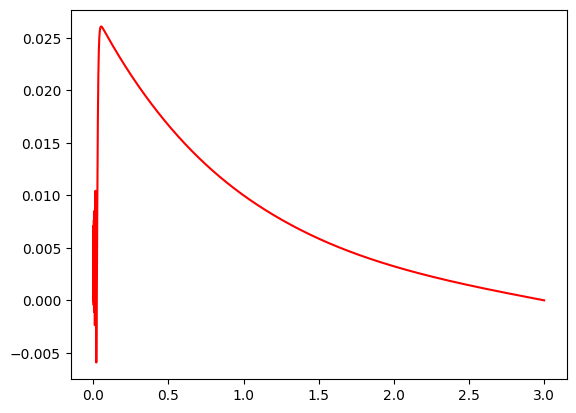

In [62]:
numerical_parameters = {
    sym_epsilon: 1e-2,
    sym_h0: 1e-2,
    sym_alpha: 1e-1,
    sym_theta: 1e-2
}

solution = perform_numerical_experiment(numerical_parameters = numerical_parameters, display_result = True, verbose = True)

In [22]:
solution.dPsi_partial0

(0.03824295457749438-0.10930166586907135j)